<a href="https://colab.research.google.com/github/sahinya17/ANN-Electricity-data/blob/main/ETC5555_Electricity_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("keras")
install.packages("tensorflow")
library(tensorflow)
install_tensorflow(method = "auto")

library(keras)
install_keras(method = c("conda"), conda = "auto", tensorflow = "default",
              extra_packages = c("tensorflow-hub"))

install.packages("tidyverse")
install.packages("DataExplorer")
install.packages("caret")

In [ ]:
%%R
library(tidyverse)
library(DataExplorer)
library(tensorflow)
library(keras)
library(caret)

In [6]:
%%R
data <- read.csv("Electricity_data_Poland.csv") %>% select(!X)

nnet_data <- data %>% 
  separate(time, into = c("time_from", "time_to"), sep = " - ") %>% 
  mutate(time_from = as.factor(time_from),
         Date = as.Date(Date, format = "%d-%m-%Y"),
         totalLoad = as.numeric(totalLoad))

nnet_data[rowSums(is.na(nnet_data)) > 0,"totalLoad"] <- nnet_data[(which(is.na(nnet_data), arr.ind=TRUE)[1,1])-1,"totalLoad"]

nnet_data <- data.matrix(nnet_data[,'totalLoad'])

mean <- mean(nnet_data)
std <- sd(nnet_data)
nnet_data <- scale(nnet_data, center = mean, scale = std)


generator <- function(data, lookback, delay, min_index, max_index,
                      shuffle = FALSE, batch_size, step = 1){
  if (is.null(max_index))
    max_index <- nrow(data) - delay - 1
  i <- min_index + lookback
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size-1, max_index))
      i <<- i + length(rows)
    }
    
    samples <- array(0, dim = c(length(rows),
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))

    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]]-1,
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices,]
      targets[[j]] <- data[rows[[j]] + delay,]
    }           
    list(samples, targets)
  }
}

lookback <- 24*365
step <- 1
delay <- 0
batch_size <- 128
train_gen <- generator(
  nnet_data,
  lookback = lookback,
  delay = delay,
  min_index = 1,
  max_index = 40000,
  shuffle = FALSE,
  step = step,
  batch_size = batch_size)

train_gen_data <- train_gen()

lookback <- 24*365
step <- 1
delay <- 0
batch_size_plot <- 11240
  pred_gen <- generator(
    nnet_data,
    lookback = lookback,
    delay = delay,
    min_index = 40000,
    max_index = 60000,
    shuffle = FALSE,
    step = step,
    batch_size = batch_size_plot)

pred_gen_data <- pred_gen()


In [7]:
%%R
model <- keras_model_sequential() %>%
  layer_flatten(input_shape = c(lookback / step, 1)) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 1)

summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten (Flatten)                  (None, 8760)                    0           
 dense_2 (Dense)                    (None, 128)                     1121408     
 dense_1 (Dense)                    (None, 64)                      8256        
 dense (Dense)                      (None, 1)                       65          
Total params: 1,129,729
Trainable params: 1,129,729
Non-trainable params: 0
________________________________________________________________________________


In [8]:
%%R

model %>% compile(optimizer = optimizer_rmsprop(),
                  loss = "mae")

history <- model %>% fit(
  train_gen_data[[1]],train_gen_data[[2]],
  batch_size = batch_size,
  epochs = 50,
  use_multiprocessing = T
)


Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.5395
Epoch 2/50
1/1 [==============================] - 0s 68ms/step - loss: 20.7387
Epoch 3/50
1/1 [==============================] - 0s 48ms/step - loss: 5.5749
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 4.1456
Epoch 5/50
1/1 [==============================] - 0s 38ms/step - loss: 2.8139
Epoch 6/50
1/1 [==============================] - 0s 44ms/step - loss: 1.8056
Epoch 7/50
1/1 [==============================] - 0s 44ms/step - loss: 1.9042
Epoch 8/50
1/1 [==============================] - 0s 43ms/step - loss: 1.3530
Epoch 9/50
1/1 [==============================] - 0s 37ms/step - loss: 1.9751
Epoch 10/50
1/1 [==============================] - 0s 35ms/step - loss: 1.4786
Epoch 11/50
1/1 [==============================] - 0s 38ms/step - loss: 1.5402
Epoch 12/50
1/1 [==============================] - 0s 49ms/step - loss: 1.7118
Epoch 13/50
1/1 [==============================] - 0s 37ms/ste

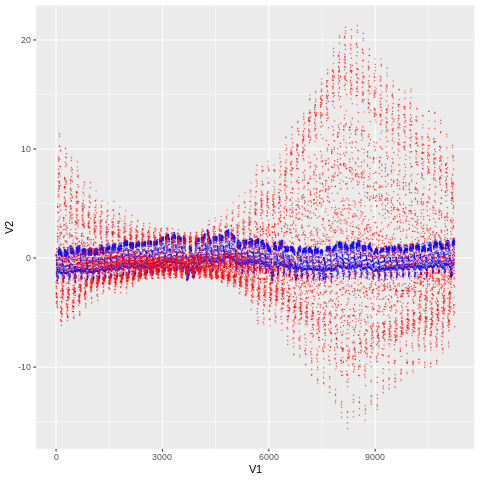

In [15]:
%%R
V1 = seq(1, length(pred_gen_data[[2]]))
  
plot_data <- as.data.frame(cbind(V1, pred_gen_data[[2]]))
  
inputdata <- pred_gen_data[[1]]
dim(inputdata) <- c(batch_size_plot, lookback, 1)
  
pred_out <- model %>% predict(inputdata) 
  
plot_data <- cbind(plot_data, pred_out)
  
p <- ggplot(plot_data, aes(x = V1, y = V2)) + geom_point(colour = "blue", size = 0.1,alpha=0.4)
p <- p + geom_point(aes(x = V1, y = pred_out), colour = "red", size = 0.1 ,alpha=0.4)
  
p